## CAMB


In [1]:
from halos import Catalog, Cosmo
from astropy.cosmology import LambdaCDM, z_at_value
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import astropy.units as u
from scipy.interpolate import make_interp_spline

import camb
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
from camb import model, initialpower


h_Hubble = 0.67

%matplotlib inline

In [2]:
cosmo = Cosmo()
nside = 512
npix = hp.nside2npix(nside)
snapshot_numbers = range(48, 63)
nside_in = 4096
nside_out = 512

/opt/miniconda3/lib/python3.12/site-packages/scipy/optimize/_optimize.py:2972: RuntimeWarning: overflow encountered in scalar divide
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


In [3]:
mass_inf = 0

halo_map = np.zeros(npix)
z_shell = []
halos_number = []
halos_redshift = []
diff = []
for snapshot in snapshot_numbers:
    print(f"Snapshot n: {snapshot}")
    catalog = Catalog(snapshot)
    print(f"Numer of halos: {catalog.get_n_halos()}")
    catalog_selection = catalog.select_mass_above(mass_inf)
    print(f"Number of halos (M>{mass_inf}): {catalog_selection.get_n_halos()} \n")
    del catalog
    
    catalog_selection.compute_pixel(nside)
    halo_map[catalog_selection.pixel] += 1

    catalog_selection.compute_redshift()
    halos_redshift.append(catalog_selection.halos_redshift)
    
    z_shell.append(catalog_selection.redshift)
    halos_number.append(catalog_selection.get_n_halos())
    diff.append(catalog_selection.z_end - catalog_selection.z_start)

halos_redshift = np.concatenate(halos_redshift)

bin_edges = np.linspace(0, 0.485510, 501)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # Centri dei bin
halo_counts, _ = np.histogram(halos_redshift, bins=bin_edges)  

# Normalizza
bin_widths = np.diff(bin_edges)
halos_density = halo_counts / bin_widths

Snapshot n: 48
Reading AllSkyMock_snap_048_0.bin0...
Reading AllSkyMock_snap_048_1.bin0...
Reading AllSkyMock_snap_048_2.bin0...
Reading AllSkyMock_snap_048_3.bin0...
Numer of halos: 4400733
Number of halos (M>0): 4400733 

Snapshot n: 49
Reading AllSkyMock_snap_049_0.bin0...
Reading AllSkyMock_snap_049_1.bin0...
Reading AllSkyMock_snap_049_2.bin0...
Reading AllSkyMock_snap_049_3.bin0...
Numer of halos: 3656099
Number of halos (M>0): 3656099 

Snapshot n: 50
Reading AllSkyMock_snap_050_0.bin0...
Reading AllSkyMock_snap_050_1.bin0...
Reading AllSkyMock_snap_050_2.bin0...
Reading AllSkyMock_snap_050_3.bin0...
Numer of halos: 2272139
Number of halos (M>0): 2272139 

Snapshot n: 51
Reading AllSkyMock_snap_051_0.bin0...
Reading AllSkyMock_snap_051_1.bin0...
Reading AllSkyMock_snap_051_2.bin0...
Reading AllSkyMock_snap_051_3.bin0...
Numer of halos: 1898259
Number of halos (M>0): 1898259 

Snapshot n: 52
Reading AllSkyMock_snap_052_0.bin0...
Reading AllSkyMock_snap_052_1.bin0...
Reading AllSk

In [4]:
cmb_map_sum = np.zeros(npix)
for snapshot in snapshot_numbers:
    
    map_file = f'KappaMap_snap_{snapshot:03d}.DM.seed_100672.fits'
    print(f"Reading {map_file}")
    
    z_l = cosmo.from_snapshot_get(snapshot, 'z')
    cmb_weight = cosmo.from_snapshot_get(snapshot, 'cmb_weight')
    cmb_map = cosmo.lens_weight(z_l, 0.485510) * (1/cmb_weight) * hp.read_map(map_file)
    
    cmb_map_downgraded = hp.ud_grade(cmb_map, nside)
    cmb_map_sum += cmb_map_downgraded

Reading KappaMap_snap_048.DM.seed_100672.fits
Reading KappaMap_snap_049.DM.seed_100672.fits
Reading KappaMap_snap_050.DM.seed_100672.fits
Reading KappaMap_snap_051.DM.seed_100672.fits
Reading KappaMap_snap_052.DM.seed_100672.fits
Reading KappaMap_snap_053.DM.seed_100672.fits
Reading KappaMap_snap_054.DM.seed_100672.fits
Reading KappaMap_snap_055.DM.seed_100672.fits
Reading KappaMap_snap_056.DM.seed_100672.fits
Reading KappaMap_snap_057.DM.seed_100672.fits
Reading KappaMap_snap_058.DM.seed_100672.fits
Reading KappaMap_snap_059.DM.seed_100672.fits
Reading KappaMap_snap_060.DM.seed_100672.fits
Reading KappaMap_snap_061.DM.seed_100672.fits
Reading KappaMap_snap_062.DM.seed_100672.fits


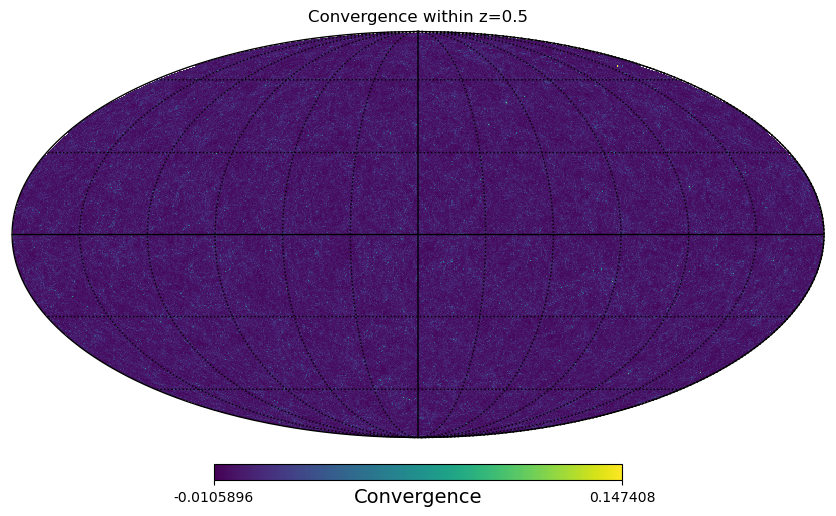

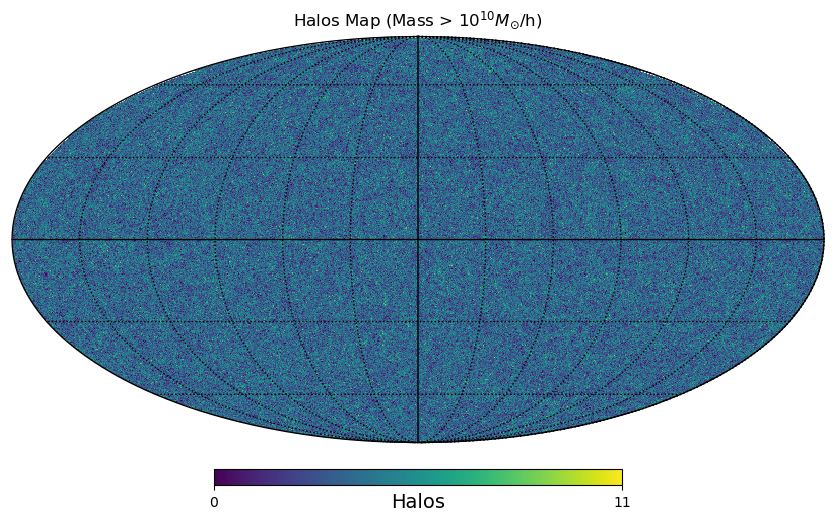

In [5]:
hp.mollview(cmb_map_sum, title="Convergence within z=0.5", unit="Convergence")
hp.graticule()
plt.show()

# Display the halo map
hp.mollview(halo_map, title=r'Halos Map (Mass > $10^{10} M_{\odot}$/h)', unit='Halos')
hp.graticule()
plt.show()

In [6]:
#------------------ CROSS CORRELATION ----------------------
mean_halo_count = np.mean(halo_map)
halo_contrast = (halo_map - mean_halo_count) / mean_halo_count
cross_correlation_kappa = hp.anafast(halo_contrast, cmb_map_sum, lmax=2*nside)
cross_correlation_kappa_kappa = hp.anafast(cmb_map_sum, cmb_map_sum, lmax=2*nside)
cross_correlation_halos_halos = hp.anafast(halo_contrast, halo_contrast, lmax=2*nside)

import pickle
with open("halo_data_516.pkl", "wb") as f:
    pickle.dump({
        "cross_correlation_kappa": cross_correlation_kappa,
        "cross_correlation_kappa_kappa": cross_correlation_kappa_kappa,
        "cross_correlation_halos_halos": cross_correlation_halos_halos
    }, f)

In [7]:
#import pickle
# Apri il file e leggi i dati
#with open("halo_data_516.pkl", "rb") as f:
#    data = pickle.load(f)

# Estrai le variabili
#cross_correlation_kappa = data["cross_correlation_kappa"]
#cross_correlation_kappa_kappa = data["cross_correlation_kappa_kappa"]
#cross_correlation_halos_halos = data["cross_correlation_halos_halos"]

In [8]:
# Simulation params
OmegaCDM = 0.27
OmegaBr = 0.05
OmegaNeu = 0.00
OmegaLambda = 0.68
h_Hubble = 0.67
OmegaR0 = 9.2865e-5  # Densità di radiazione
Omega0 = OmegaCDM + OmegaBr  # Densità totale della materia
H0 = h_Hubble * 100  # km/s/Mpc

lmax = len(cross_correlation_kappa)
l = np.arange(2, len(cross_correlation_kappa))

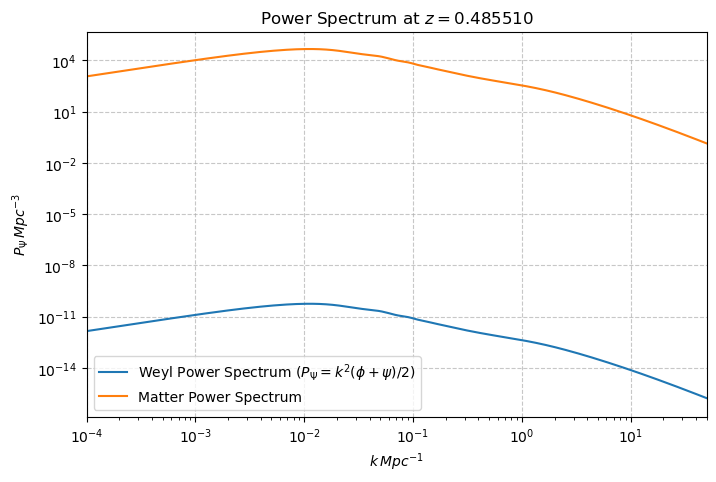

In [9]:
#CAMB params
pars = camb.CAMBparams()
pars.set_cosmology(H0=67, ombh2=OmegaBr * h_Hubble ** 2, omch2= OmegaCDM * h_Hubble ** 2)
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.set_for_lmax(lmax, lens_potential_accuracy=2)
#set Want_CMB to true if you also want CMB spectra or correlations
#pars.Want_CMB = False 
#NonLinear_both or NonLinear_lens will use non-linear corrections
pars.NonLinear = model.NonLinear_both


# Power Spectrum

nz = 100 #number of steps to use for the radial/redshift integration
kmax = 50
#For Limber result, want integration over \chi (comoving radial distance), from 0 to chi_*.
#so get background results to find chistar, set up a range in chi, and calculate corresponding redshifts
results= camb.get_background(pars)# Imposta il redshift per il quale vogliamo ottenere chi_star
z_star = 0.485510
# Ottieni la distanza comovente associata a z_star
chi_star = results.comoving_radial_distance(z_star)
# Calcola la griglia di chi da 0 fino a chi_star (incluso) per l'integrazione
chis = np.linspace(0, chi_star, nz)
# Calcola i redshift corrispondenti a ciascun punto della griglia di chi
zs = results.redshift_at_comoving_radial_distance(chis)

# Calcola la differenza tra i punti successivi della griglia chi
dchis = (chis[2:] - chis[:-2]) / 2
chis = chis[1:-1]
zs = zs[1:-1]



#Get the matter power spectrum interpolation object (based on RectBivariateSpline). 
#Here for lensing we want the power spectrum of the Weyl potential.
PK = camb.get_matter_power_interpolator(pars, nonlinear=True, 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_Weyl,var2=model.Transfer_Weyl, zmax=zs[-1])

PK_tot = camb.get_matter_power_interpolator(pars, nonlinear=True, 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_tot,var2=model.Transfer_tot, zmax=zs[-1])

#Have a look at interpolated power spectrum results for a range of redshifts
#Expect linear potentials to decay a bit when Lambda becomes important, and change from non-linear growth
plt.figure(figsize=(8,5))
k = np.exp(np.log(10)*np.linspace(-4,2,200))
zplot = [0, 0.485510, 1, 4,20]
plt.loglog(k, PK.P(0.485510, k), label = r'Weyl Power Spectrum ($P_\Psi = k^2(\phi + \psi)/2$)')
plt.loglog(k, PK_tot.P(0.485510, k), label = r'Matter Power Spectrum')
plt.title(r"Power Spectrum at $z=0.485510$")
plt.xlim([1e-4,kmax])
plt.xlabel(r'$k \,  Mpc^{-1}$')
plt.ylabel(r'$P_\Psi \, Mpc^{-3}$')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

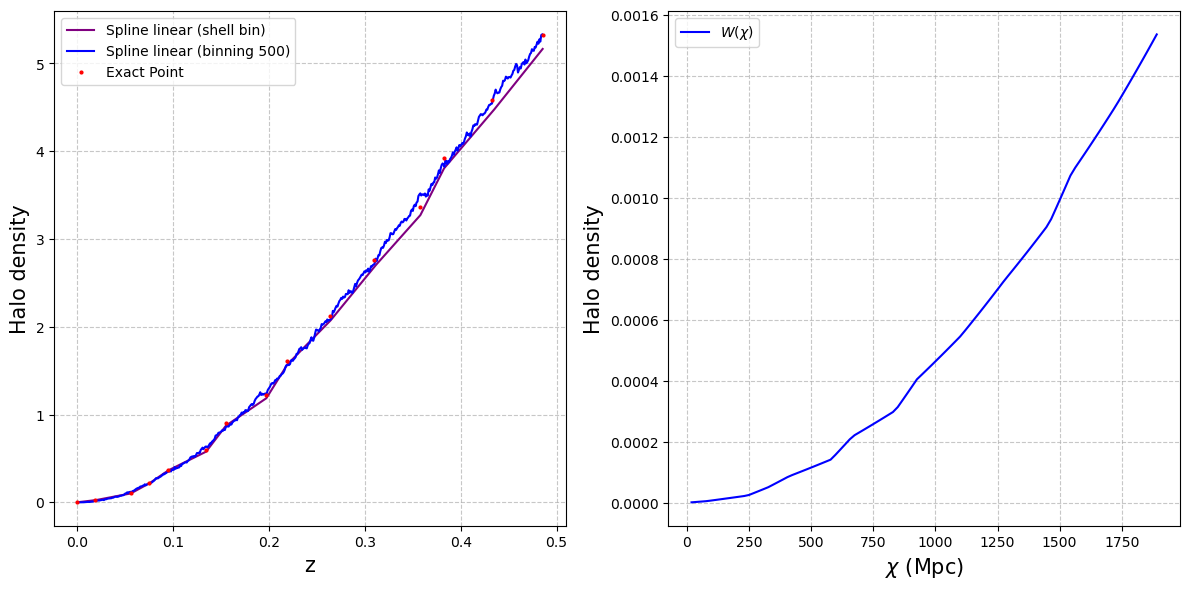

In [10]:
# Halo denisity

# redshift
n_z = make_interp_spline(z_shell[::-1], np.array(halos_number[::-1])/ np.array(diff[::-1]), k = 1)
z = np.linspace(0, 0.485510, 10000)
n_zs = n_z(z)
integrale_n_z = np.trapezoid(n_zs, z)
n_zs = n_zs/integrale_n_z

# comoving distance
H_z = results.hubble_parameter(zs)  # H(z) in km/s/Mpc
c = 3e5
dz_dchi = H_z / c  # Calcola dz/dχ
W_chi = n_z(zs) * dz_dchi 
integrale_W_chi = np.trapezoid(W_chi, chis)
W_chi = W_chi/integrale_W_chi


# PLOT
plt.figure(figsize=(12, 6))  
plt.subplot(1, 2, 1)
plt.plot(z, n_zs, color="purple", label="Spline linear (shell bin)")
plt.plot(bin_centers, halos_density/integrale_W_chi, color="blue", label="Spline linear (binning 500)")
plt.plot(z_shell[::-1], np.array(halos_number[::-1])/ np.array(diff[::-1])/integrale_W_chi, marker="o", markersize=2, linestyle="None", color="red", label="Exact Point")

plt.ylabel("Halo density", fontsize=15)
plt.xlabel("z", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

# Secondo grafico: distribuzione W(χ)
plt.subplot(1, 2, 2)
plt.plot(chis, W_chi, label=r"$W(\chi)$", color='b')
plt.xlabel(r"$\chi$ (Mpc)", fontsize=15)
plt.ylabel("Halo density", fontsize=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Mostra i grafici
plt.tight_layout()
plt.show()

In [11]:
# CAMB
#Set up W(z) window functions, later labelled W1, W2. Gaussian here.
pars.SourceWindows = [
    #SplinedSourceWindow(z = bin_centers, W = halos_density, source_type='counts'),
    SplinedSourceWindow(z = z, W = n_zs, source_type='counts'),
    GaussianSourceWindow(redshift=0.485510, source_type='lensing', sigma=1e-2)]

results = camb.get_results(pars)
cls = results.get_source_cls_dict()

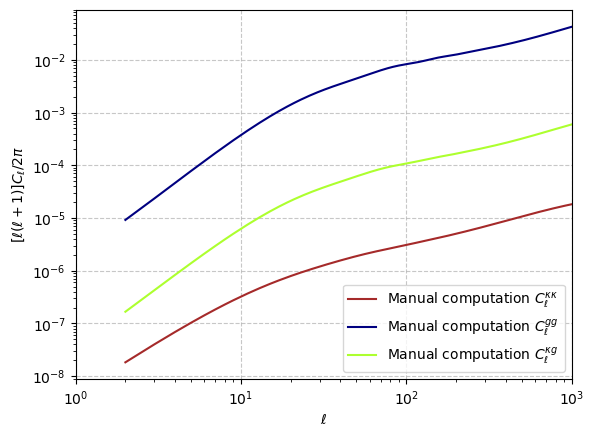

In [12]:
#Get lensing window function (flat universe)
win = ((chi_star-chis)/(chis**2*chi_star))

#Do integral over chi
ls = np.arange(2, lmax, dtype=np.float64)
cl_kappa=np.zeros(ls.shape)
cl_g=np.zeros(ls.shape)
cl_gkappa=np.zeros(ls.shape)
w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
for i, l in enumerate(ls):
    k=(l+0.5)/chis
    w[:]=1
    w[k<1e-4]=0
    w[k>=kmax]=0
    cl_kappa[i] = np.dot(dchis, w*PK.P(zs, k, grid=False)*(win**2)/(k**4))
    cl_g[i] = np.dot(dchis, w*PK_tot.P(zs, k, grid=False)*(W_chi**2)/(chis**2))
    cl_gkappa[i] = np.dot(dchis, w*PK.P(zs, k, grid=False) / (k**2) * (W_chi) * win)
cl_kappa*= (ls*(ls+1))**2
cl_gkappa *= ls * (ls + 1) *28032.48582271681

plt.loglog(ls,cl_kappa * ls *(ls +1) /(2*np.pi), color='brown', label = r"Manual computation $C_\ell^{\kappa \kappa}$")
plt.loglog(ls, cl_g *ls *(ls +1) /(2*np.pi), color='navy', label = r"Manual computation $C_\ell^{g g}$")
plt.loglog(ls, cl_gkappa *ls *(ls +1) /(2*np.pi), color='greenyellow', label = r"Manual computation $C_\ell^{\kappa g}$")
plt.xlim([1,1e3])
plt.legend()
plt.ylabel(r'$[\ell(\ell+1)]C_\ell/2\pi$')
plt.xlabel(r'$\ell$')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

1025


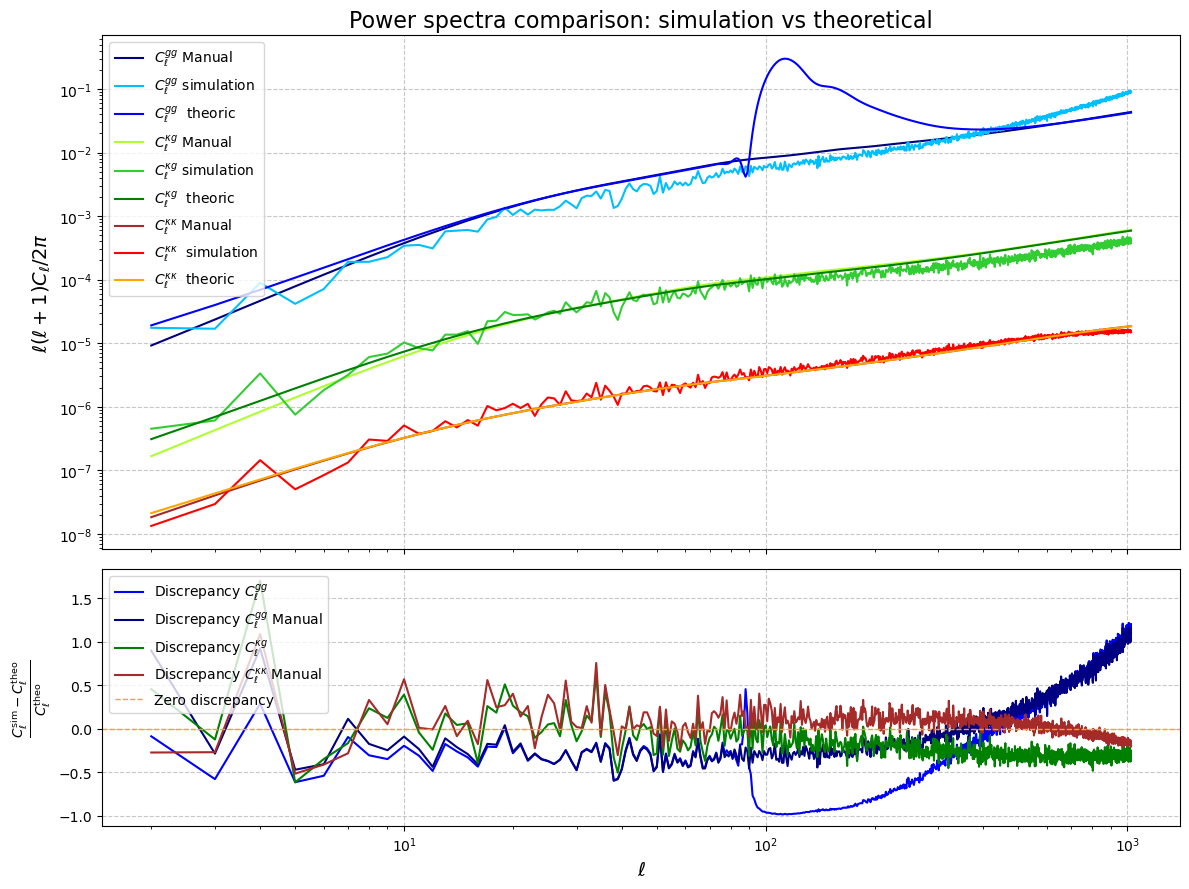

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9), sharex=True, gridspec_kw={"height_ratios": [2, 1]})

l = np.arange(2, len(cross_correlation_kappa))
print(len(cross_correlation_kappa))

ax1.loglog(ls, cl_g *(ls)*(ls+1)/(2*np.pi), label = r'$C_\ell^{g g}$ Manual', color='navy')
ax1.plot(l, cross_correlation_halos_halos[2:] * l * (l + 1)/(2 * np.pi), label = r'$C_\ell^{gg}$ simulation', color='deepskyblue')
ax1.loglog(l, cls['W1xW1'][2:lmax], label = r'$C_\ell^{gg}$  theoric', color='blue')

ax1.loglog(ls, cl_gkappa *(ls)*(ls+1)/(2*np.pi), label = r'$C_\ell^{\kappa g}$ Manual', color='greenyellow')
ax1.plot(l, cross_correlation_kappa[2:] * l * (l + 1)/(2 * np.pi), label=r'$C_\ell^{\kappa g}$ simulation', color='limegreen')
ax1.loglog(l, cls['W1xW2'][2:lmax], label = r'$C_\ell^{\kappa g}$  theoric', color='green')

ax1.loglog(ls, cl_kappa *(ls)*(ls+1)/(2*np.pi), label = r'$C_\ell^{\kappa \kappa}$ Manual', color='brown')
ax1.plot(l, cross_correlation_kappa_kappa[2:] * l * (l + 1)/(2 * np.pi), label = r'$C_\ell^{\kappa \kappa}$  simulation', color='red')
ax1.loglog(l, cls['W2xW2'][2:lmax], label = r'$C_\ell^{\kappa \kappa}$  theoric', color='orange')

# Titoli e legende
ax1.set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi$', fontsize=14)
ax1.legend(fontsize=10)
ax1.set_title('Power spectra comparison: simulation vs theoretical', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)

# Calcolo discrepanze
discrepancy_gg = ((cross_correlation_halos_halos[2:]) - cl_g) / cl_g
discrepancy_gg_err = ((cross_correlation_halos_halos[2:] * l * (l + 1)/(2 * np.pi)) - cls['W1xW1'][2:lmax]) / cls['W1xW1'][2:lmax]
discrepancy_kappag = ((cross_correlation_kappa[2:] * l * (l + 1)/(2 * np.pi)) - cls['W1xW2'][2:lmax]) / cls['W1xW2'][2:lmax]
discrepancy_kappakappa = ((cross_correlation_kappa_kappa[2:] ) - cl_kappa) / cl_kappa

# Grafico discrepanze
ax2.plot(l, discrepancy_gg_err, label=r'Discrepancy $C_\ell^{gg}$', color='blue')
ax2.plot(l, discrepancy_gg, label=r'Discrepancy $C_\ell^{gg}$ Manual', color='navy')
ax2.plot(l, discrepancy_kappag, label=r'Discrepancy $C_\ell^{\kappa g}$', color='green')
ax2.plot(l, discrepancy_kappakappa, label=r'Discrepancy $C_\ell^{\kappa \kappa}$ Manual', color='brown')
ax2.axhline(0, color='orange', linestyle='--', linewidth=1, label='Zero discrepancy')

# Asse delle x e legende
ax2.set_xlabel(r'$\ell$', fontsize=14)
ax2.set_ylabel(r'$\frac{C_\ell^{\rm sim} - C_\ell^{\rm theo}}{C_\ell^{\rm theo}}$', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.7)

# Adattamento layout
plt.tight_layout()
plt.show()


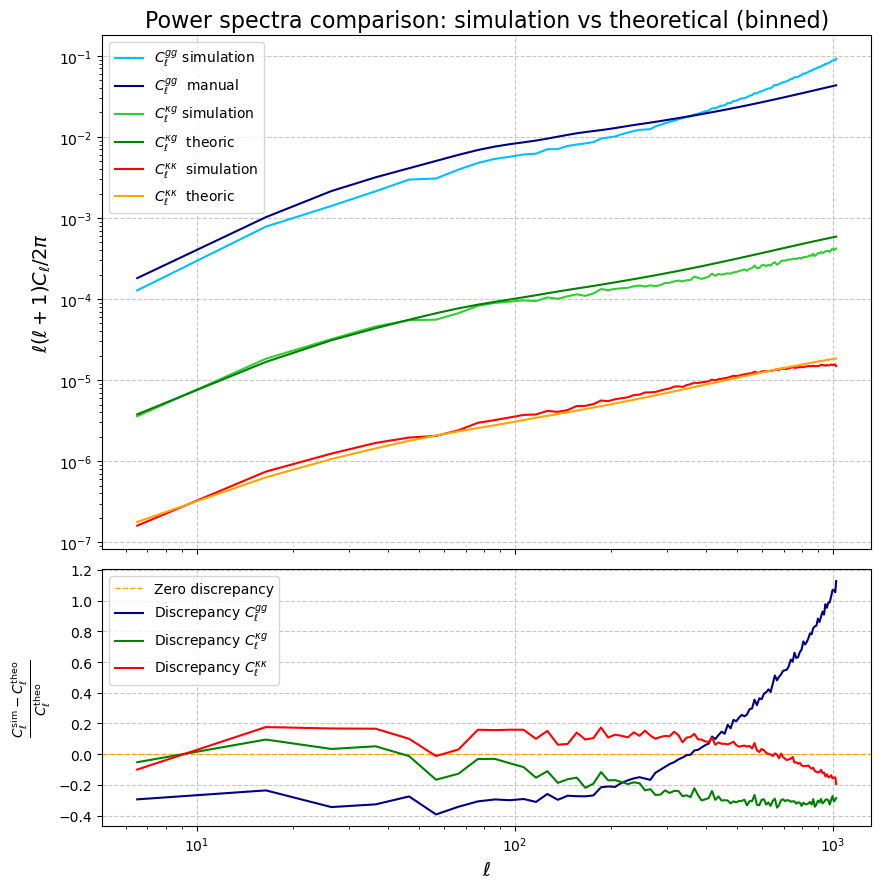

In [14]:
# Funzione per il binning
def binning(data, binsize):
    return np.array([np.mean(data[i:i+binsize]) for i in range(0, len(data), binsize)])

# Applica il binning ogni 10 l
binsize = 10
l_binned = binning(l, binsize)
cross_correlation_halos_halos_binned = binning(cross_correlation_halos_halos[2:], binsize)
cls_W1xW1_binned = binning(cl_g * ls * (ls + 1)/(2*np.pi), binsize)
cross_correlation_kappa_binned = binning(cross_correlation_kappa[2:], binsize)
cls_W1xW2_binned = binning(cls['W1xW2'][2:lmax], binsize)
cross_correlation_kappa_kappa_binned = binning(cross_correlation_kappa_kappa[2:], binsize)
cls_W2xW2_binned = binning(cls['W2xW2'][2:lmax], binsize)

# Calcolo discrepanze binned
discrepancy_gg_binned = (cross_correlation_halos_halos_binned * l_binned * (l_binned + 1)/(2 * np.pi) - cls_W1xW1_binned) / cls_W1xW1_binned
discrepancy_kappag_binned = (cross_correlation_kappa_binned * l_binned * (l_binned + 1)/(2 * np.pi) - cls_W1xW2_binned) / cls_W1xW2_binned
discrepancy_kappakappa_binned = (cross_correlation_kappa_kappa_binned * l_binned * (l_binned + 1)/(2 * np.pi) - cls_W2xW2_binned) / cls_W2xW2_binned

# Grafico
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 9), sharex=True, gridspec_kw={"height_ratios": [2, 1]})

# Grafico principale
ax1.plot(l_binned, cross_correlation_halos_halos_binned * l_binned * (l_binned + 1)/(2 * np.pi), label=r'$C_\ell^{gg}$ simulation', color='deepskyblue')
ax1.loglog(l_binned, cls_W1xW1_binned, label=r'$C_\ell^{gg}$  manual', color='navy')
ax1.plot(l_binned, cross_correlation_kappa_binned * l_binned * (l_binned + 1)/(2 * np.pi), label=r'$C_\ell^{\kappa g}$ simulation', color='limegreen')
ax1.loglog(l_binned, cls_W1xW2_binned, label=r'$C_\ell^{\kappa g}$  theoric', color='green')
ax1.plot(l_binned, cross_correlation_kappa_kappa_binned * l_binned * (l_binned + 1)/(2 * np.pi), label=r'$C_\ell^{\kappa \kappa}$  simulation', color='red')
ax1.loglog(l_binned, cls_W2xW2_binned, label=r'$C_\ell^{\kappa \kappa}$  theoric', color='orange')

# Titoli e legende
ax1.set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi$', fontsize=14)
ax1.legend(fontsize=10)
ax1.set_title('Power spectra comparison: simulation vs theoretical (binned)', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)

# Grafico discrepanze
ax2.axhline(0, color='orange', linestyle='--', linewidth=1, label='Zero discrepancy')
ax2.plot(l_binned, discrepancy_gg_binned, label=r'Discrepancy $C_\ell^{gg}$', color='navy')
ax2.plot(l_binned, discrepancy_kappag_binned, label=r'Discrepancy $C_\ell^{\kappa g}$', color='green')
ax2.plot(l_binned, discrepancy_kappakappa_binned, label=r'Discrepancy $C_\ell^{\kappa \kappa}$', color='red')

# Asse delle x e legende
ax2.set_xlabel(r'$\ell$', fontsize=14)
ax2.set_ylabel(r'$\frac{C_\ell^{\rm sim} - C_\ell^{\rm theo}}{C_\ell^{\rm theo}}$', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.7)

# Adattamento layout
plt.tight_layout()
plt.show()
